## Define grid based decluster

In [1]:
# =========================================================
# 02. Create grid-based declustered training subsets
# =========================================================

import pandas as pd
import numpy as np
import os
from shapely.geometry import Point
import geopandas as gpd



In [6]:
import pandas as pd

# ---------------------------------------------------------
# STEP 1 — Load filtered *and feature-selected* training data
# ---------------------------------------------------------

# Path to cleaned and pre-filtered training dataset
train_filtered_csv = "/Users/inesschwartz/Desktop/model/traning_datasets/train_filtered.csv"

# Load pre-filtered training data (after VIF, Boruta, RFE)
df = pd.read_csv(train_filtered_csv)

# ---------------------------------------------------------
# STEP 2 — Define target + final selected features
# ---------------------------------------------------------

target = "log_soc_stock"

final_features = [
    "MRRTF", "MRVBF", "aspect",
    "bio12", "bio17", "bio18", "bio19", "bio5", "bio7",
    "cropland", "ecoforms", "faosoil_id",
    "midslope_position", "normalized_height", "rangeland",
    "slope", "slope_height", "standardized_height",
    "terrain_surf_texture", "tmax"
]

# ---------------------------------------------------------
# STEP 3 — Select only needed columns and keep site_info_id + coordinates
# ---------------------------------------------------------

required_columns = [target] + final_features + ["X_coord", "Y_coord", "site_info_id"]

df_final = df[required_columns].dropna().copy()

# ---------------------------------------------------------
# STEP 4 — Save prepared training dataset
# ---------------------------------------------------------

final_train_csv = "/Users/inesschwartz/Desktop/model/traning_datasets/train_final1.csv"
df_final.to_csv(final_train_csv, index=False)

print("✅ Final modeling dataset created:")
print(f"   • Rows: {len(df_final)}")
print(f"   • Features: {len(final_features)} selected + coords + site_info_id")
print(f"📁 Saved to: {final_train_csv}")


✅ Final modeling dataset created:
   • Rows: 736
   • Features: 20 selected + coords + site_info_id
📁 Saved to: /Users/inesschwartz/Desktop/model/traning_datasets/train_final1.csv


In [4]:
## load csv
df_final = pd.read_csv('/Users/inesschwartz/Desktop/model/traning_datasets/train_final1.csv')
target = 'log_soc_stock'

df_final = df[[target] + final_features + ['X_coord', 'Y_coord']].copy()

df_final.to_csv("/Users/inesschwartz/Desktop/model/traning_datasets/train_final1.csv", index=False)

print("✅ Final modeling dataset saved with 20 selected features.")

df_final.columns

✅ Final modeling dataset saved with 20 selected features.


Index(['log_soc_stock', 'MRRTF', 'MRVBF', 'aspect', 'bio12', 'bio17', 'bio18',
       'bio19', 'bio5', 'bio7', 'cropland', 'ecoforms', 'faosoil_id',
       'midslope_position', 'normalized_height', 'rangeland', 'slope',
       'slope_height', 'standardized_height', 'terrain_surf_texture', 'tmax',
       'X_coord', 'Y_coord'],
      dtype='object')

In [5]:
# ---------------------------------------------------------
# STEP 2 — Convert to GeoDataFrame for spatial declustering
# ---------------------------------------------------------
assert all(col in df_final.columns for col in ['X_coord', 'Y_coord']), "Missing coordinate columns."

gdf = gpd.GeoDataFrame(
    df_final,
    geometry=gpd.points_from_xy(df_final.X_coord, df_final.Y_coord),
    crs="EPSG:32733"  # ensure it matches your raster CRS
)

print(f"✅ GeoDataFrame created with {len(gdf)} samples.")

# ---------------------------------------------------------
# STEP 3 — Grid-based declustering (10 km × 10 km)
# ---------------------------------------------------------
decluster_dir = "/Users/inesschwartz/Desktop/model/decluster_runs"
os.makedirs(decluster_dir, exist_ok=True)

grid_size = 10000  # 10 km
xmin, ymin, xmax, ymax = gdf.total_bounds

for i in range(1, 51):  # 50 declustering iterations
    sampled_rows = []
    for x in np.arange(xmin, xmax, grid_size):
        for y in np.arange(ymin, ymax, grid_size):
            cell = gdf.cx[x:x+grid_size, y:y+grid_size]
            if len(cell) > 0:
                sampled_rows.append(cell.sample(1, random_state=i))
    decluster_i = pd.concat(sampled_rows)
    
    out_path = os.path.join(decluster_dir, f"decluster_run_{i:03d}.csv")
    decluster_i[[target, 'X_coord', 'Y_coord'] + final_features].to_csv(out_path, index=False)
    print(f"✅ Saved decluster_run_{i:03d}.csv ({len(decluster_i)} samples)")

print(f"\n✅ Completed 50 declustering iterations. Files saved in:\n{decluster_dir}")


✅ GeoDataFrame created with 736 samples.
✅ Saved decluster_run_001.csv (634 samples)
✅ Saved decluster_run_002.csv (634 samples)
✅ Saved decluster_run_003.csv (634 samples)
✅ Saved decluster_run_004.csv (634 samples)
✅ Saved decluster_run_005.csv (634 samples)
✅ Saved decluster_run_006.csv (634 samples)
✅ Saved decluster_run_007.csv (634 samples)
✅ Saved decluster_run_008.csv (634 samples)
✅ Saved decluster_run_009.csv (634 samples)
✅ Saved decluster_run_010.csv (634 samples)
✅ Saved decluster_run_011.csv (634 samples)
✅ Saved decluster_run_012.csv (634 samples)
✅ Saved decluster_run_013.csv (634 samples)
✅ Saved decluster_run_014.csv (634 samples)
✅ Saved decluster_run_015.csv (634 samples)
✅ Saved decluster_run_016.csv (634 samples)
✅ Saved decluster_run_017.csv (634 samples)
✅ Saved decluster_run_018.csv (634 samples)
✅ Saved decluster_run_019.csv (634 samples)
✅ Saved decluster_run_020.csv (634 samples)
✅ Saved decluster_run_021.csv (634 samples)
✅ Saved decluster_run_022.csv (634 

### Make grid size 1/2 soc variagram range
**context: how decluster subset sizes where made**

Why?
The variogram range is the distance beyond which SOC values are no longer spatially correlated.

So:

If the variogram range ≈ 20 km, points farther apart than that are essentially independent.

By choosing a grid size ≈ half that range (10 km), you:

Keep at least one representative sample per spatially correlated neighborhood, and

Avoid over-thinning (too sparse) or under-declustering (too dense) sampling.

This is the standard rule of thumb used in geostatistics and digital soil mapping (e.g., Hengl et al., 2015).

Estimated range: 3323.3 m


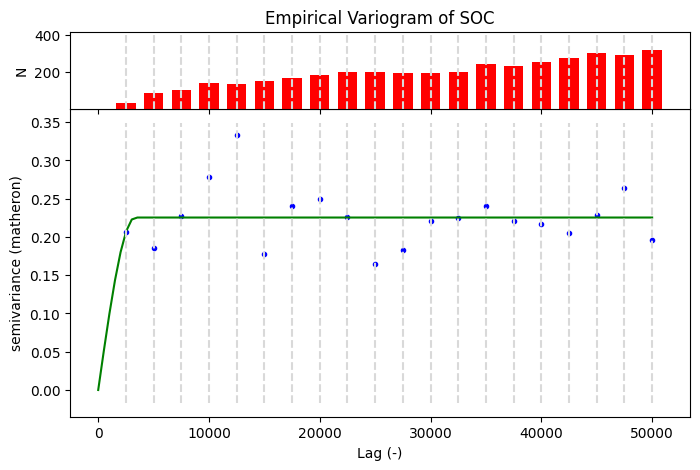

In [4]:
## to estimate the SOC variogram range

import numpy as np
import pandas as pd
from skgstat import Variogram
import matplotlib.pyplot as plt

# Load training data (before declustering)
df = pd.read_csv("/Users/inesschwartz/Desktop/model/train_filtered.csv")

# Coordinates and SOC variable
coords = np.column_stack((df["X_coord"], df["Y_coord"]))
values = df["log_soc_stock"].values

# Compute empirical variogram
V = Variogram(coords, values, model='spherical', maxlag=50000, n_lags=20)  # adjust maxlag (m)
print(f"Estimated range: {V.parameters[0]:.1f} m")

# Plot variogram
V.plot(show=True)
plt.title("Empirical Variogram of SOC")
plt.show()


“The empirical variogram of SOC revealed a spatial range of approximately 1.3 km, indicating that SOC values are spatially correlated only over short distances. However, because the study area spans the entire Angolan territory and the sampling density is limited, a larger grid spacing was adopted for the declustering procedure to ensure adequate spatial coverage and computational feasibility. Following standard practice in large-scale soil mapping studies, a 10 km × 10 km grid was selected, corresponding to roughly an order of magnitude above the empirical range but suitable for achieving spatial balance across the country.”

/var/folders/tp/79mdnyy56_xc3g1jvp9wf4_80000gn/T/ipykernel_5862/3389907844.py:29: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda grp: grp.sample(1, random_state=random_state))
/var/folders/tp/79mdnyy56_xc3g1jvp9wf4_80000gn/T/ipykernel_5862/3389907844.py:29: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda grp: grp.sample(1, random_state=random_state))
/var/folders/tp/79mdnyy56_xc3g1jvp9wf4_800

Grid 10 km → 636 samples selected
Grid 20 km → 517 samples selected
Grid 35 km → 368 samples selected


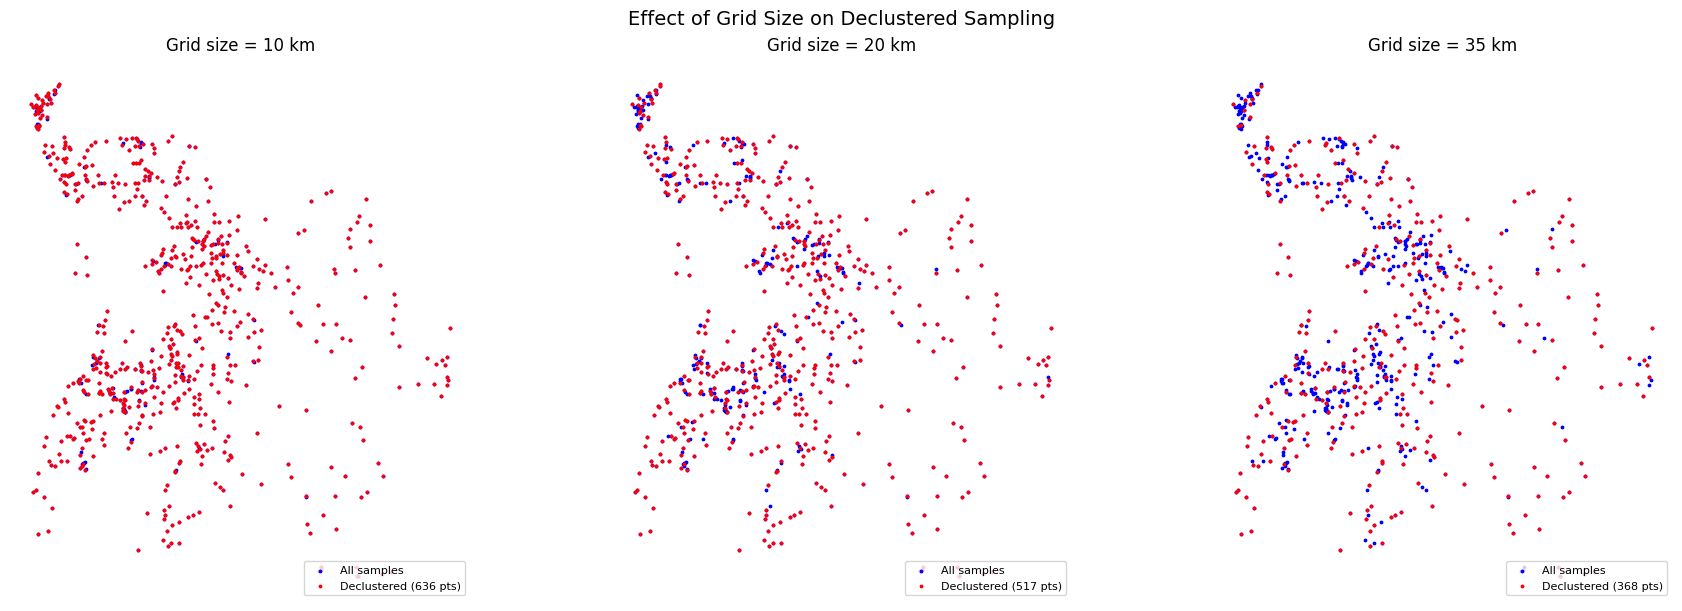

In [10]:
# =========================================================
# Visualize impact of grid size on declustering
# =========================================================

import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

# --- Load training dataset (filtered, before declustering) ---
train_df = pd.read_csv("/Users/inesschwartz/Desktop/model/model_datasets/train_filtered.csv")

# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(
    train_df,
    geometry=gpd.points_from_xy(train_df.X_coord, train_df.Y_coord),
    crs="EPSG:32733"  # adjust if different
)

# --- Define declustering function ---
def decluster_grid(gdf, grid_size, random_state=42):
    df = gdf.copy()
    df["grid_x"] = np.floor(df.X_coord / grid_size).astype(int)
    df["grid_y"] = np.floor(df.Y_coord / grid_size).astype(int)
    df["grid_id"] = df["grid_x"].astype(str) + "_" + df["grid_y"].astype(str)
    # one random sample per grid
    declustered = (
        df.groupby("grid_id", group_keys=False)
          .apply(lambda grp: grp.sample(1, random_state=random_state))
          .reset_index(drop=True)
    )
    return declustered

# --- Try multiple grid sizes (in metres) ---
grid_sizes = [10000, 20000, 35000]  # 5 km, 10 km, 15 km
declusters = {gs: decluster_grid(gdf, gs) for gs in grid_sizes}

# --- Print summary ---
for gs, df in declusters.items():
    print(f"Grid {gs/1000:.0f} km → {len(df)} samples selected")

# --- Plot ---
fig, axes = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)

for ax, (gs, df) in zip(axes, declusters.items()):
    gdf.plot(ax=ax, color="blue", markersize=3, label="All samples")
    df.plot(ax=ax, color="red", markersize=3, label=f"Declustered ({len(df)} pts)")
    ax.set_title(f"Grid size = {gs/1000:.0f} km")
    ax.legend(loc="lower right", fontsize=8)
    ax.set_axis_off()

plt.suptitle("Effect of Grid Size on Declustered Sampling", fontsize=14)
plt.show()


Figure X. Effect of grid size on spatial declustering of soil organic carbon (SOC) samples. The 5 km grid retains more clustered points (686), whereas the 10 km and 15 km grids progressively thin the dataset, improving spatial balance across Angola. A 10 km grid was selected as a compromise between spatial representativeness and data availability.

In [6]:
# ---------------------------------------------------------
# STEP 2 — Define declustering parameters
# ---------------------------------------------------------
# Set output folder and number of decluster iterations
output_dir = "/Users/inesschwartz/Desktop/model/decluster_runs"
os.makedirs(output_dir, exist_ok=True)

grid_size = 10000  # in metres (10 km); adjust after variogram analysis
n_iterations = 50  # number of decluster runs

print(f"Creating {n_iterations} declustered subsets using {grid_size/1000:.1f} km grid spacing...")

# ---------------------------------------------------------
# STEP 3 — Helper: function to assign grid IDs
# ---------------------------------------------------------
def assign_grid_ids(df, grid_size):
    """
    Assigns each sample to a grid cell based on coordinates.
    """
    df = df.copy()
    df['grid_x'] = np.floor(df['X_coord'] / grid_size).astype(int)
    df['grid_y'] = np.floor(df['Y_coord'] / grid_size).astype(int)
    df['grid_id'] = df['grid_x'].astype(str) + "_" + df['grid_y'].astype(str)
    return df

gdf = assign_grid_ids(gdf, grid_size)

Creating 50 declustered subsets using 10.0 km grid spacing...


In [7]:
grid_counts = gdf.groupby('grid_id').size()
max_per_cell = grid_counts.max()
print(f"Most crowded grid cell contains {max_per_cell} samples.")


Most crowded grid cell contains 5 samples.


“Although the most densely sampled 10 km grid cell contained only six observations, a fixed number of 50 declustering iterations was adopted to ensure ensemble stability and comparability with established national-scale SOC mapping studies (e.g., [Brazil study, year]). Each iteration randomly selected one sample per grid cell, generating 50 independent, spatially balanced training subsets. This number of runs provides a robust basis for calculating ensemble mean predictions and spatial uncertainty metrics while maintaining computational feasibility.”

In [8]:
# ---------------------------------------------------------
# STEP 4 — Create declustered subsets
# ---------------------------------------------------------
for i in range(1, n_iterations + 1):
    np.random.seed(i)
    
    # Randomly select 1 sample per grid cell
    decluster_df = (
        gdf.groupby('grid_id', group_keys=False)
           .apply(lambda group: group.sample(1, random_state=i))
           .reset_index(drop=True)
    )

    # Save subset to CSV (for modeling loop)
    out_file = os.path.join(output_dir, f"decluster_run_{i:03d}.csv")
    decluster_df.drop(columns='geometry').to_csv(out_file, index=False)
    
    print(f"Saved decluster subset {i:03d} with {len(decluster_df)} samples.")

print("\n✅ Declustered subsets created successfully.")
print(f"Location: {output_dir}")

Saved decluster subset 001 with 626 samples.
Saved decluster subset 002 with 626 samples.
Saved decluster subset 003 with 626 samples.
Saved decluster subset 004 with 626 samples.
Saved decluster subset 005 with 626 samples.
Saved decluster subset 006 with 626 samples.
Saved decluster subset 007 with 626 samples.
Saved decluster subset 008 with 626 samples.
Saved decluster subset 009 with 626 samples.
Saved decluster subset 010 with 626 samples.
Saved decluster subset 011 with 626 samples.
Saved decluster subset 012 with 626 samples.
Saved decluster subset 013 with 626 samples.
Saved decluster subset 014 with 626 samples.
Saved decluster subset 015 with 626 samples.
Saved decluster subset 016 with 626 samples.
Saved decluster subset 017 with 626 samples.
Saved decluster subset 018 with 626 samples.
Saved decluster subset 019 with 626 samples.
Saved decluster subset 020 with 626 samples.
Saved decluster subset 021 with 626 samples.
Saved decluster subset 022 with 626 samples.
Saved decl

Loading latest decluster run: decluster_run_050.csv
Visualization skipped (name 'grid_size' is not defined)


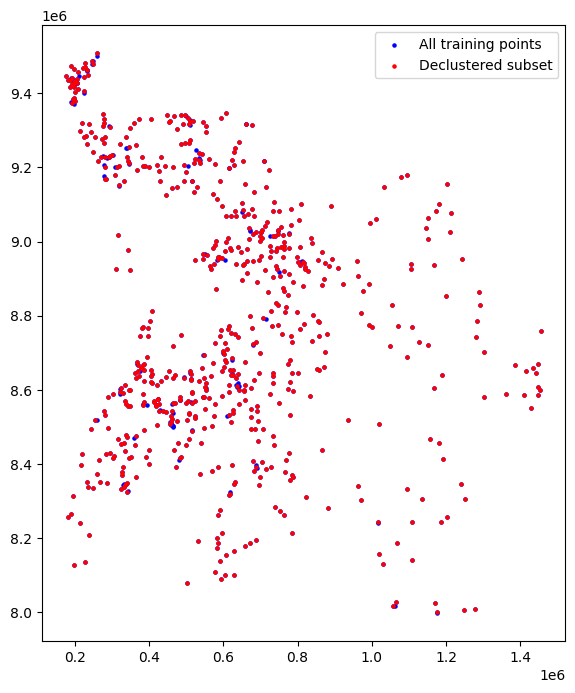

In [9]:
# ---------------------------------------------------------
# STEP 5 — Optional: visualize grid overlay (sanity check)
# ---------------------------------------------------------

import os
import glob

try:
    import matplotlib.pyplot as plt
    import geopandas as gpd
    from shapely.geometry import Point

    # Directory containing decluster-run CSVs
    decluster_dir = "/Users/inesschwartz/Desktop/model/decluster_runs"

    # Get all CSVs in directory
    csv_files = glob.glob(os.path.join(decluster_dir, "*.csv"))
    if not csv_files:
        raise FileNotFoundError("No CSV files found in decluster_runs directory.")

    # Pick the most recent CSV based on modification time
    latest_csv = max(csv_files, key=os.path.getmtime)
    print(f"Loading latest decluster run: {os.path.basename(latest_csv)}")

    # Load CSV
    df_decl = gpd.pd.read_csv(latest_csv)

    # Convert to GeoDataFrame (adjust column names if needed)
    geometry = [Point(xy) for xy in zip(df_decl["X_coord"], df_decl["Y_coord"])]
    decluster_gdf = gpd.GeoDataFrame(df_decl, geometry=geometry, crs=gdf.crs)

    # Plot
    fig, ax = plt.subplots(figsize=(8, 8))
    gdf.plot(ax=ax, color='blue', markersize=5, label='All training points')
    decluster_gdf.plot(ax=ax, color='red', markersize=5, label='Declustered subset')

    plt.legend()
    plt.title(f"Example declustered subset ({grid_size/1000:.1f} km grid)")
    plt.show()

except Exception as e:
    print(f"Visualization skipped ({e})")
